In [1]:
from __future__ import division, print_function
%matplotlib inline

In [2]:
from future.builtins import next

In [3]:
import numpy as np

In [4]:
import qinfer as qi
import qutip as qt

In [5]:
import itertools as it
from functools import partial

In [6]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [7]:
I, X, Y, Z = qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()

In [8]:
basis = qi.tomography.pauli_basis(2)
model = qi.BinomialModel(qi.tomography.TomographyModel(basis))
prior = qi.tomography.GinibreDistribution(basis)

In [9]:
fiducial_measurement = qt.ket2dm(qt.tensor([qt.basis(2, 0)] * 2))
fiducial_measurement

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]
 [ 0.  0.  0.  0.]]

In [10]:
X_pi  = (-1j * np.pi * X / 2).expm()
X_pi2 = (-1j * np.pi * X / 4).expm()
Y_pi2 = (-1j * np.pi * Y / 4).expm()

In [11]:
measurement_operators = [
    U * fiducial_measurement * U.dag()
    for U in it.starmap(qt.tensor, it.product(*([
        [I, X_pi, X_pi2, Y_pi2]
    ] * 2)))
]
measurement_operators += [
    qt.tensor(I, I) - op for op in measurement_operators
]

In [12]:
expparams = np.empty(
    (len(measurement_operators),),
    dtype=model.expparams_dtype
)
expparams['meas'] = [basis.state_to_modelparams(op) for op in measurement_operators]
expparams['n_meas'] = 50

In [13]:
def cycle_heuristic(expparams):
    
    def heuristic(updater):
        return partial(next, it.cycle(expparams[:, np.newaxis]))
    
    return heuristic

In [14]:
perf = qi.perf_test_multiple(200,
    model, 6000, prior,
    len(expparams), cycle_heuristic(expparams),
    progressbar=qi.IPythonProgressBar
)

/home/cgranade/anaconda3/lib/python3.5/site-packages/QInfer-1.0-py3.5.egg/qinfer/utils.py:268: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
  warnings.warn('Numerical error in covariance estimation causing positive semidefinite violation.', ApproximationWarning)


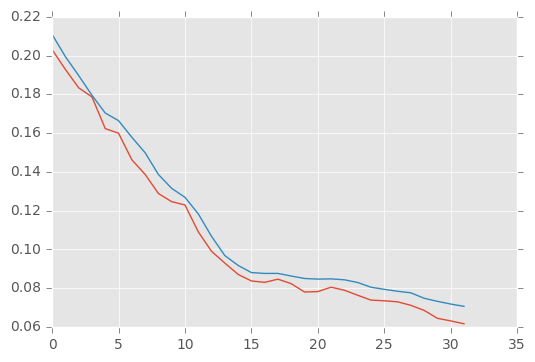

In [15]:
plt.plot(np.median(perf['loss'], axis=0))
plt.plot(np.mean(perf['loss'], axis=0))

## Updater Loop ##

In [45]:
expparams['n_meas'] = 100

In [55]:
true_state = qt.tensor([qt.Qobj(
    [
        [0.9, 0.01 + 0.01j],
        [0.01 - 0.01j, 0.1]
    ]
)] * 2)

In [56]:
true_mps = basis.state_to_modelparams(true_state)[np.newaxis, :]

In [57]:
updater = qi.SMCUpdater(model, 12000, prior)
# We use np.newaxis here to make sure that
# experiment is a 1D array within the body of the
# loop.
for experiment in expparams[:, np.newaxis]:
    datum = model.simulate_experiment(true_mps, experiment)
    updater.update(datum, experiment)

/home/cgranade/anaconda3/lib/python3.5/site-packages/QInfer-1.0-py3.5.egg/qinfer/smc.py:285: ApproximationWarning: Extremely small n_ess encountered (3.0250880469009043). Resampling is likely to fail. Consider adding particles, or resampling more often.
  ApproximationWarning
/home/cgranade/anaconda3/lib/python3.5/site-packages/QInfer-1.0-py3.5.egg/qinfer/utils.py:268: ApproximationWarning: Numerical error in covariance estimation causing positive semidefinite violation.
  warnings.warn('Numerical error in covariance estimation causing positive semidefinite violation.', ApproximationWarning)


In [58]:
est_state = basis.modelparams_to_state(updater.est_mean())

In [59]:
est_state

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 0.69258861+0.j         -0.04306205+0.04297341j  0.02785794+0.03399417j
   0.06769224-0.00929301j]
 [-0.04306205-0.04297341j  0.12809561+0.j         -0.01177088+0.00517686j
   0.00473614-0.00909154j]
 [ 0.02785794-0.03399417j -0.01177088-0.00517686j  0.08191759+0.j
   0.00238023+0.02828578j]
 [ 0.06769224+0.00929301j  0.00473614+0.00909154j  0.00238023-0.02828578j
   0.09739820+0.j        ]]

In [60]:
est_state - true_state

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[-0.11741139+0.j         -0.05206205+0.03397341j  0.01885794+0.02499417j
   0.06769224-0.00949301j]
 [-0.05206205-0.03397341j  0.03809561+0.j         -0.01197088+0.00517686j
   0.00373614-0.01009154j]
 [ 0.01885794-0.02499417j -0.01197088-0.00517686j -0.00808241+0.j
   0.00138023+0.02728578j]
 [ 0.06769224+0.00949301j  0.00373614+0.01009154j  0.00138023-0.02728578j
   0.08739820+0.j        ]]

([<matplotlib.axis.XTick at 0x7f1fd20349e8>,
 <a list of 16 Text xticklabel objects>)

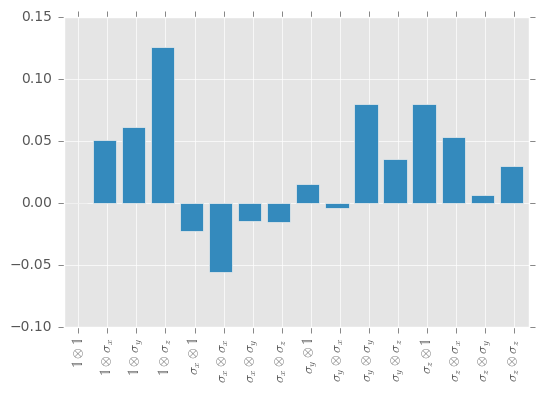

In [76]:
plt.bar(np.arange(16), (true_mps - updater.est_mean())[0, :])
plt.xticks(np.arange(16) + 0.5, map("${}$".format, basis.labels), rotation='vertical')

NB: we omit the traceful part (modelparam 0) when taking the hull. The convex hull algorithm (quickhull) is fast in the number of points, but very slow in the number of dimensions, so this call will take a long time.

In [ ]:
faces, vertices = updater.region_est_hull(modelparam_slice=np.s_[1:])